# Part 1: Simple Gaussian Model with BBVI

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Generate data from a simple model: Normal(10, 1)
data = np.random.normal(loc = 10, scale = 1, size = 100)

## Model specification


<img src="mean_model.png" width="600">

## Manual estimation of the gradient of the ELBO for the above model

In [2]:
# Gradient estimator using sampling -- vanilla BBVI
# We here assume the model X ~ Normal(mu, 1)
# with unknown mu, that in itself is Normal, mean 0 and standard deviation 1000, 
# so effectively an uniformed prior. 
# The variational dstribution for mu is also Normal, with parameter q_mu_lambda
# -- taking the role of lambda in the calculations -- and variance 1.

def grad_estimate(q_mu_lambda, samples = 1):
    # sum_grad_estimate will hold the sum as we move along over the <samples> samples. 
    sum_grad_estimate = 0
    for i in range(samples):
        # Sample one example from current best guess for the variational distribution
        mu_sample = np.random.normal(loc=q_mu_lambda, scale=1, size=1)
        
        # Now we want to calculate the contribution from this sample, namely 
        # [log p(x, mu_sample) - log q(mu|lambda) ] * grad( log q(mu_sample|lambda) )
        #
        # First log p(x|mu_sample) + log p(mu_sample) - log q(mu_sample|lambda) 
        value = np.sum(norm.logpdf(data, loc=mu_sample, scale=1)) 
        + norm.logpdf(mu_sample, loc = 0, scale = 1000)  
        - norm.logpdf(mu_sample, loc= q_mu_lambda, scale = 1)
        
        # Next grad (log q(mu_sample|lambda))
        # The Normal distribution gives the score function with known variance as <value> - <mean>
        grad_q = mu_sample - q_mu_lambda
        
        # grad ELBO for this sample is therefore in total given by
        sum_grad_estimate = sum_grad_estimate + grad_q * value
        
    # Divide by number of samples to get average value -- the estimated expectation  
    return sum_grad_estimate/samples

## Checking the variation in gradient estimate

M =  1 sample(s) in BBVI -- Mean of gradient:  64.429; Std.dev. of gradient: 317.714
M =  2 sample(s) in BBVI -- Mean of gradient: 113.991; Std.dev. of gradient: 264.659
M =  3 sample(s) in BBVI -- Mean of gradient: 118.492; Std.dev. of gradient: 235.832
M =  4 sample(s) in BBVI -- Mean of gradient:  94.690; Std.dev. of gradient: 197.284
M =  5 sample(s) in BBVI -- Mean of gradient: 103.494; Std.dev. of gradient: 166.981
M = 10 sample(s) in BBVI -- Mean of gradient:  92.752; Std.dev. of gradient: 126.697
M = 25 sample(s) in BBVI -- Mean of gradient:  98.161; Std.dev. of gradient:  76.097


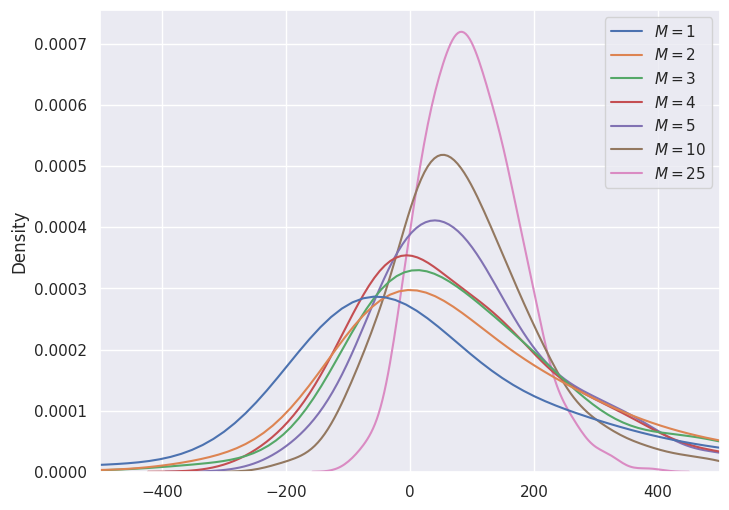

In [3]:
# To check the variation / "unreliability" of the gradient estimate we repeat 
# several times for the same lambda value and notice difference

# Location to check -- close to the data mean (at +10). 
# The prior will move the variational optimium **slightly** away from the data mean, 
# but due to the large prior variance of mu this should be a very limited effect.
# We should therefore expect a positive derivative (since we want to move 
# q_mu_lambda towards the data mean, that is, **increase** it)
q_mu_lambda = 9

plt.figure(figsize=(8,6))
sns.set()
grad_est = {}
# Do with different sample sizes
for sample_count in [1, 2, 3, 4, 5, 10, 25]:

    #loop
    q_grad = []
    for t in range(500):
        q_grad.append(grad_estimate(q_mu_lambda, samples=sample_count)[0])
 
    grad_est["$M = {:d}$".format(sample_count)] = q_grad
    
    # Report back
    print("M = {:2d} sample(s) in BBVI -- Mean of gradient: {:7.3f}; Std.dev. of gradient: {:7.3f}".format(
        sample_count, np.mean(q_grad), np.std(q_grad)))

df = pd.DataFrame(grad_est)
sns.kdeplot(data=df)    
plt.xlim([-500, 500])
plt.show()      

## Exercise

* What can we say about the gradient estimate based on the plots above?
* Implement and test your own gradient ascent learning algorithm starting from, say, q_mu_lambda=-10. Experiment with different learning rates, number of samples used for the gradient estimate, possibly supplemented with momentum.
* Optional: Adapt the implementation above so that we can also learn the variance of the q distribution 

In [4]:
def gradient_descent(q_mu_lambda, learning_rate, samples):
    # Calculate gradient estimate
    grad_est = grad_estimate(q_mu_lambda, samples)
    return q_mu_lambda + learning_rate * grad_est[0]

In [5]:
gradient_descent(q_mu_lambda, 0.1, 1)

67.7929665383769

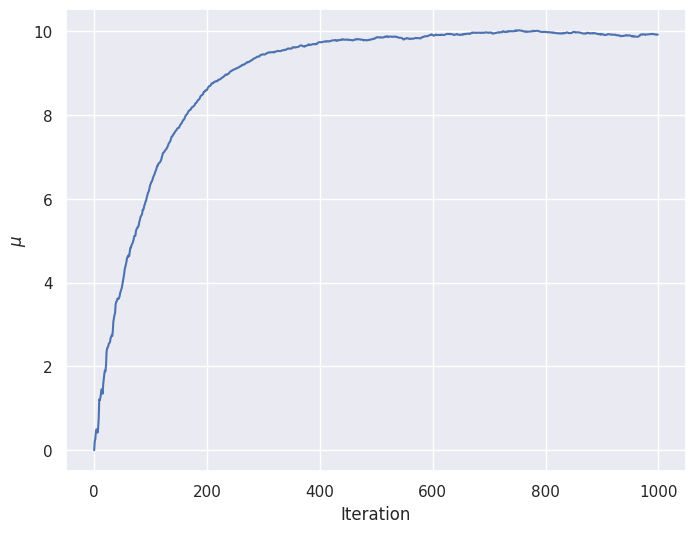

In [6]:
# Run gradient descent for a number of steps
q_mu_lambda = 0
learning_rate = 0.0001
steps = 1000
q_mu_lambda_history = []
for step in range(steps):
    q_mu_lambda_history.append(q_mu_lambda)
    q_mu_lambda = gradient_descent(q_mu_lambda, learning_rate, samples=25)

# Plot the history of mu
plt.figure(figsize=(8,6))
sns.set()
plt.plot(q_mu_lambda_history)
plt.xlabel("Iteration")
plt.ylabel("$\mu$")
plt.show()

# Part 2: Thumb tack

In [7]:
import pyro
import torch
from pyro.optim import SGD, Adam
import pyro.distributions as dist
from torch.distributions import constraints
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/home/ebog/enviorments/PyTorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model
We consider the thumb tack model (to see the figures you should be logged in to Moodle):

<img src="thumb_tack.png" width="600">

Recall the beta distribution 

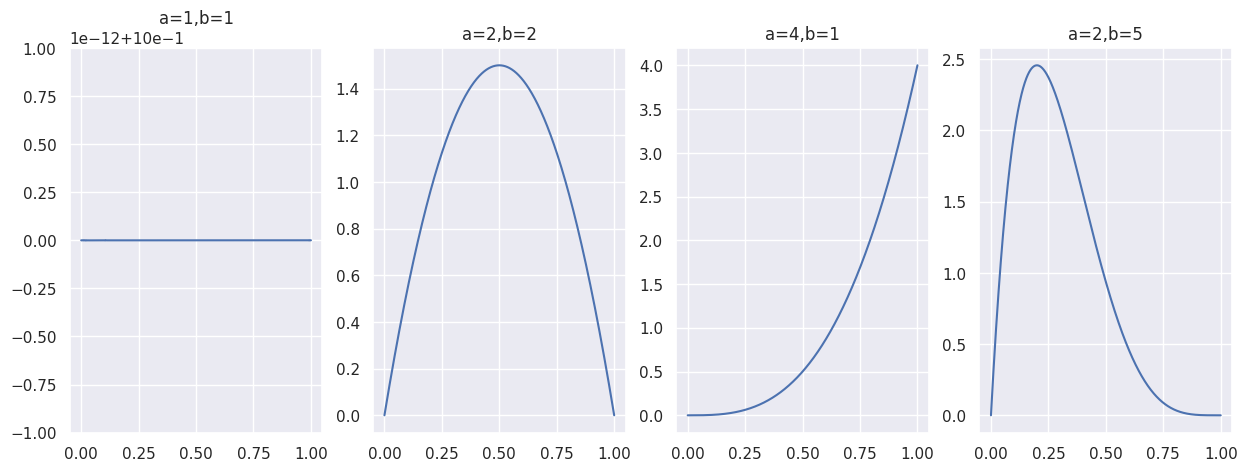

In [8]:
parameters = [(1,1), (2,2), (4,1),(2,5)]
x = np.linspace(0,1,1000)
plt.figure(figsize=(15, 5))
for idx, para in enumerate(parameters):
    plt.subplot(1, len(parameters), idx+1)
    y = beta.pdf(x, *para)
    plt.title(f'a={para[0]},b={para[1]}')
    plt.plot(x,y)

## The model

Here we define the probabilistic model. Notice the close resemblance with the plate specification above.

In [9]:
# Defines the thumb_tack model. The 'data' is a 0-1 tensor of type float  
def thumb_tack_model(data):  
    
    # Define the random variable theta
    theta = pyro.sample("theta", dist.Beta(2.0,5.0))
    
    # and now the plate holding the observations. The number of observations are determined by the data set 
    # supplied to the function
    with pyro.plate("thumb_tack_plate"):
        pyro.sample(f"obs", dist.Bernoulli(probs=theta), obs=data)

## The variational distribution

In Pyro the variational distribution is defined as a so-called guide. In this example our variational distribution is a beta distribution with parameters q_alpha and q_beta:

$$
q(\theta)= \mathit{Beta}(\theta | \alpha, \beta)
$$

In [10]:
def thumb_tack_guide(data):

    # We initialize the variational parameters q_alpha and q_beta to 1.0. Also, we constrain the parameters to be positive as per 
    # definition of the distribution
    q_alpha = pyro.param("q_alpha", torch.tensor(1.0), constraint=constraints.positive)
    q_beta = pyro.param("q_beta", torch.tensor(1.0), constraint=constraints.positive)

    # The name of the random variable of the variational distribution must match the name of the corresponding
    # variable in the model exactly.
    pyro.sample("theta", dist.Beta(q_alpha, q_beta))

## Learning

For optimizing the ELBO we rely on a standard stochastic gradient descent

In [11]:
def thumb_tack_learn(data, num_iter=5000):

    pyro.clear_param_store()

    # Define the ELBO and the optimization function
    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=thumb_tack_model,
                         guide=thumb_tack_guide,
                         optim=SGD({'lr':0.001}),
                         loss=elbo)

    # Perform a fixed number of gradient steps
    num_steps = num_iter
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 100 == 0:
            print(f"Loss for iteration {step}: {loss}")

## Analyze

Let's take a look at the learned variational distribution 

In [12]:
def thumb_tack_analyze(data):

    # Get the values of the variational parameters
    q_alpha = pyro.param("q_alpha").item()
    q_beta = pyro.param("q_beta").item()

    mean = q_alpha/(q_alpha + q_beta)
    std = q_alpha*q_beta/(((q_alpha+q_beta)**2)*(q_alpha + q_beta + 1.0))

    print(f"Mean: {mean}")
    print(f"Standard deviation: {std}")

    x = np.linspace(0.0, 1.0, 1000)
    plt.plot(x, beta.pdf(x, q_alpha, q_beta), label='Variational dist.')
    plt.plot(x,beta.pdf(x, data[data==1].shape[0]+1,data[data==0].shape[0]+1), label='True dist.')
    plt.legend()

## Perform experiments

In [13]:
# The data consists of 20 pin ups ('1') and 80 pin down ('0'). Squeeze is just used to compress the dimensions 
# from 2 to 1
data = torch.cat((torch.ones(20, 1), torch.zeros(80, 1))).squeeze()

# Do learning
thumb_tack_learn(data, num_iter=1000)

Loss for iteration 0: 49.54336166381836


Loss for iteration 100: 50.86390781402588
Loss for iteration 200: 56.8610520362854
Loss for iteration 300: 51.985472679138184
Loss for iteration 400: 56.52934908866882
Loss for iteration 500: 50.8088493347168
Loss for iteration 600: 54.276102781295776
Loss for iteration 700: 56.896783113479614
Loss for iteration 800: 51.83700370788574
Loss for iteration 900: 51.23470401763916


## Show the results

Mean: 0.21056934779415423
Standard deviation: 0.005690314131598969


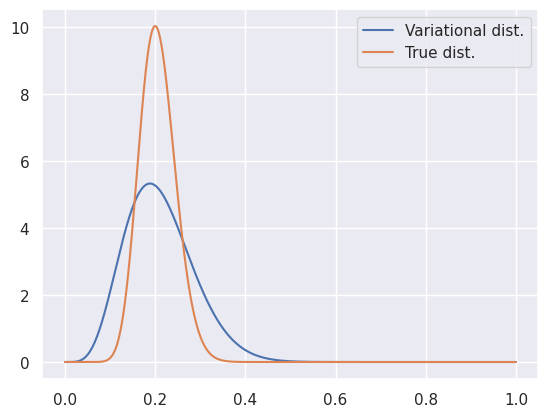

In [14]:
thumb_tack_analyze(data)

# Part 3: Exercise

## Introduction

In this exercise we will play around with the same model as in Part 1, where we derived the required gradients manually. Here we instead rely on differentiation functionality in Pyro, which, in turn is based n PyTorch.

## The model in plate notation

<img src="mean_model.png" width="600">

## The model defined in Pyro

Here we define the probabilistic model. Notice the close resemblance with the plate specification above.

In [15]:
def mean_model(data):

    # Define the random variable mu having a noral distribution as prior
    mu = pyro.sample("mu", dist.Normal(0.0,1000.0))

    # and now the plate holding the observations. The number of observations are determined by the data set 
    # supplied to the function. 
    with pyro.plate("x_plate"):
        pyro.sample("x", dist.Normal(mu, 1), obs=data)

## The variational distribution

In Pyro the variational distribution is defined as a so-called guide. In this example our variational distribution is a beta distribution with parameters q_alpha and q_beta:

$$
q(\mu)= \mathit{Normal}(\mu | q_{mu}, 1)
$$

In [16]:
def mean_guide(data):

    # We initialize the variational parameter to 0.0. 
    q_mu = pyro.param("q_mu", torch.tensor(0.0))

    # The name of the random variable of the variational distribution must match the name of the corresponding
    # variable in the model exactly.
    pyro.sample("mu", dist.Normal(q_mu, 1.0))

## Learning

Here we encapsulate the learning steps, relying on standard stochastic gradient descent

In [34]:
def learn(data):

    pyro.clear_param_store()

    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=mean_model,
                         guide=mean_guide,
                         optim=SGD({'lr':0.0001}),
                         loss=elbo)

    num_steps = 1000
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 50 == 0:
            print(f"Loss for iteration {step}: {loss}")

In [38]:
data = torch.tensor(np.random.normal(loc=10.0, scale=1.0, size=100),dtype=torch.float)
learn(data)

Loss for iteration 0: 3449.4575827121735
Loss for iteration 50: 1763.9186825752258
Loss for iteration 100: 831.7176636457443
Loss for iteration 150: 177.67714655399323
Loss for iteration 200: 181.89943516254425
Loss for iteration 250: 137.53221333026886
Loss for iteration 300: 212.98670768737793
Loss for iteration 350: 165.12150692939758
Loss for iteration 400: 150.82159596681595
Loss for iteration 450: 285.9246098995209
Loss for iteration 500: 181.90044569969177
Loss for iteration 550: 168.44474411010742
Loss for iteration 600: 160.53152358531952
Loss for iteration 650: 150.29486966133118
Loss for iteration 700: 176.19374442100525
Loss for iteration 750: 239.94701147079468
Loss for iteration 800: 154.2150012254715
Loss for iteration 850: 138.21298724412918
Loss for iteration 900: 157.5019212961197
Loss for iteration 950: 555.5878839492798


Get the learned variational parameter

In [19]:
qmu = pyro.param("q_mu").item()

In [20]:
print(f"Mean of variational distribution: {qmu}")

Mean of variational distribution: 9.896679878234863


## Exercise
* Adapt the code above to accomodate a slight more rich variational distribution, where we also have a variational parameter for the standard deviation:
$$
q(\mu)= \mathit{Normal}(\mu | q_{mu}, q_{std})
$$
* Experiment with different data sets and parameter values. Try visualizing the variational posterior distribution.

# Part 4: Self study

In this self study you will explore Pyro a bit further, but as opposed to the last self study session where focus was on modeling we will here take a slightly closer lool at (variational) inference in Pyro. 

Before starting on the self study, consider revisiting the Pyro documentation listed under reading material for the last two lectures:
* http://pyro.ai/examples/intro_long.html
* http://pyro.ai/examples/bayesian_regression.html
* http://pyro.ai/examples/svi_part_i.html

Afterwards, continue with the notebook below, where we consider (Bayesian) linear regression using Pyro based on the same setup as in the lecture. 

In [21]:
import pyro
import torch
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
import numpy as np


### Generate data
This data generation is similar to what was done during the lecture; we have one predictor variable 'x' and one response variable 'y', but here collected in a  dictionary.

In [22]:
def generate_data(N=10, true_w0= 1., true_w1=.5):
    gamma = 4.  # The *precision* in the observation noise
    st_dev = 1. / np.sqrt(gamma)  # And corresponding standard deviation
    np.random.seed(123)
    x = 5 * np.random.rand(N)  # The x-points are sampled uniformly on [0, 5]
    y = np.random.normal(loc=true_w0 + true_w1 * x, scale=st_dev)  # And the response is sampled from the Normal
    return {"x": torch.tensor(x, dtype=torch.float), "y": torch.tensor(y, dtype=torch.float)}

Helper function for visualizing the data as well as the true and learned functions

In [23]:
def data_plotter(data, true_w0=None, true_w1=None,
                 approx_w0=None, approx_w1=None):
    """
    Use to plot data. If y is not none it contains responses, and (x,y) will be scatter-plotted
    If neither true_w0 nor true_w1 is None, we will plot the line true_w0 + x * true_w1 in red.
    If neither approx_w0 nor approx_w1 is None, we plot the line approx_w0 + x * approx_w1 in green.
    """
    if data is not None:
        plt.plot(data["x"].numpy(), data["y"].numpy(), "bo")

    # Plot true line if given
    if true_w0 is not None and true_w1 is not None:
        plt.plot(data["x"].numpy(), true_w0 + true_w1 * data["x"].numpy(), "r-")

    # Plot approximation if given
    if approx_w0 is not None and approx_w1 is not None:
        plt.plot(data["x"].numpy(), approx_w0+ approx_w1* data["x"].numpy(), "g-", alpha=.2)


Generate a data set with 50 data points

In [24]:
true_w0= 1.
true_w1=.5
data = generate_data(N=10, true_w0=true_w0, true_w1=true_w1)

Plot the data together with the regression line around which the data has been generated.

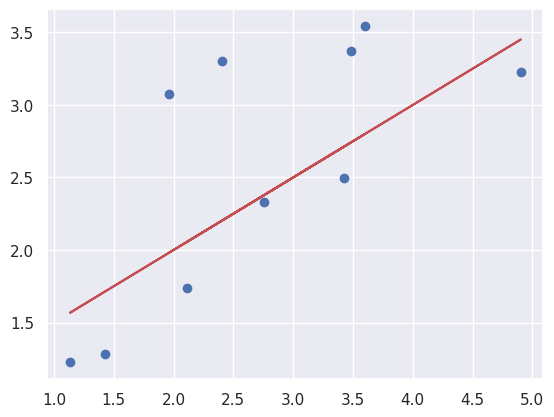

In [25]:
data_plotter(data, true_w0=true_w0, true_w1=true_w1)

## Specification of the Pyro model and guide

Here we specify a (Bayesian) linear regression model in Pyro. The 'data' argument is a dictionary covering the data of the predictor and response variable

In [26]:
def lin_reg_model(data):

    w0 = pyro.sample("w0", dist.Normal(0.0, 1000.0))
    w1 = pyro.sample("w1", dist.Normal(0.0, 1000.0))

    with pyro.plate("data_plate"):
        pyro.sample("y", dist.Normal(data["x"] * w1 + w0, 1.0), obs=data["y"])

Here we specify the variational distribution, which is called a guide in Pyro. We make the mean field assumption and assume that the variational distribution factorizes wrt. to 'w0' and 'w1'.

In [27]:
def lin_reg_guide(data):
    w0_mean = pyro.param("w0_mean", torch.tensor(0.0))
    w0_scale = pyro.param("w0_scale", torch.tensor(1.0), constraint=constraints.positive)
    pyro.sample("w0", dist.Normal(w0_mean, w0_scale))
    
    w1_mean = pyro.param("w1_mean", torch.tensor(0.0))
    w1_scale = pyro.param("w1_scale", torch.tensor(1.0), constraint=constraints.positive)
    pyro.sample("w1", dist.Normal(w1_mean, w1_scale))

### Learning

In this function the actual learning is taking place. Notice that the structure is similar to what we saw in the example notebooks during the lecture.

In [28]:
def learn(N=10, data=None):
    if data is None:
        data = generate_data(N=N)

    pyro.clear_param_store()

    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=lin_reg_model,
                         guide=lin_reg_guide,
                         optim=SGD({"lr": 0.0001}),
                         loss=elbo)

    num_steps = 5000
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 100 == 0:
            w0_mean = pyro.param("w0_mean").detach().item()
            w0_scale = pyro.param("w0_scale").detach().item()
            w1_mean = pyro.param("w1_mean").detach().item()
            w1_scale = pyro.param("w1_scale").detach().item()
            print(f"Loss (iter: {step}): {loss}")
            print(f"w0: {w0_mean} +/- {w0_scale}\t \t w1: {w1_mean} +/- {w1_scale}")

In [29]:
learn(data=data)

Loss (iter: 0): 26.41941213607788
w0: 0.0005999170825816691 +/- 1.0001208782196045	 	 w1: 0.0014474057825282216 +/- 1.0011248588562012


Loss (iter: 100): 39.09836280345917
w0: 0.15318593382835388 +/- 0.9029279947280884	 	 w1: 0.4370127022266388 +/- 0.6168984174728394
Loss (iter: 200): 26.403498589992523
w0: 0.2335812747478485 +/- 0.8195010423660278	 	 w1: 0.6569020748138428 +/- 0.46691569685935974
Loss (iter: 300): 36.929391264915466
w0: 0.27950090169906616 +/- 0.738186776638031	 	 w1: 0.7587072253227234 +/- 0.3923731744289398
Loss (iter: 400): 27.70977222919464
w0: 0.3039727210998535 +/- 0.710220456123352	 	 w1: 0.803490161895752 +/- 0.3588160276412964
Loss (iter: 500): 28.757003009319305
w0: 0.3122119605541229 +/- 0.6880441308021545	 	 w1: 0.7938001751899719 +/- 0.33001747727394104
Loss (iter: 600): 26.99584251642227
w0: 0.32759708166122437 +/- 0.6675586104393005	 	 w1: 0.811337411403656 +/- 0.3031053841114044
Loss (iter: 700): 27.525726556777954
w0: 0.3314882814884186 +/- 0.6436026692390442	 	 w1: 0.7895606756210327 +/- 0.2793603837490082
Loss (iter: 800): 27.440048336982727
w0: 0.3354315161705017 +/- 0.619757771492

### Analyze the results

Here we sample weights from the posterior distributions over 'w0' and 'w1'. The distribution of the generated weights (and the corresponding models) illustrates how confident we are in the model, an insight you cannot get when only having point estimates of the model parameters as found with, e.g., maximum likelihood learning. 

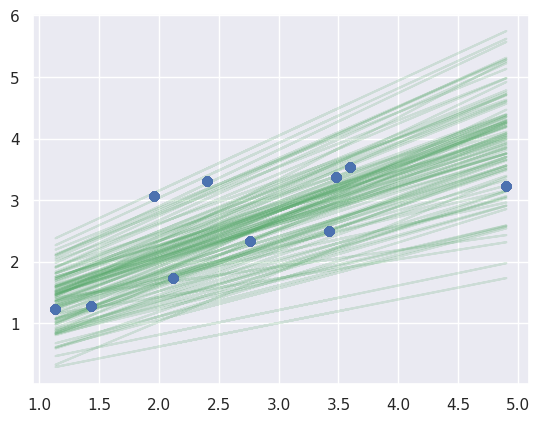

In [30]:
for _ in range(100):
    w0_mean = pyro.param("w0_mean").detach().item()
    w0_scale = pyro.param("w0_scale").detach().item()
    w1_mean = pyro.param("w1_mean").detach().item()
    w1_scale = pyro.param("w1_scale").detach().item()
    w0_sample = pyro.sample("w0_sample", dist.Normal(w0_mean, w0_scale)).numpy()
    w1_sample = pyro.sample("w1_sample", dist.Normal(w1_mean, w1_scale)).numpy()
    data_plotter(data, approx_w0=w0_sample, approx_w1=w1_sample)
data_plotter(data)
plt.show()

## Exercises:
* Generate data sets of varying sizes and characteristics (by changing the parameters in the 'generate_data' function) and investigate and compare the resulting models.
* Analyze how learning is affected by changing the learning rate and the initial values of the parameters specified in the guide function.
* Experiment with different types of prior knowledge in the model specification (e.g. change the mean and scale of the distributions over the weights). For instance, we may (mostly likely erroneously considering the data) have a prior expectation that 'w0' is around 5.0, and we can encode the strength of this belief through the scale of the corresponding distribution. 